# Anomaly Detection in Finance usign Quantum Algorithms 

## Queremos entrenar un modelo híbrido entre redes neuronales clásicas y redes neuronales cuánticas para detectar anomalías en fraude crediticio. Para esto, usaremos el dataset que se encuentra en kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud.

### Con este dataset, vamos a comparar el tiempo que demora un algoritmo matemático clásico en predecir el fraude contra el mismo parámetro para nuestro algorítmo cuántico. La base del algoritmo es una red neuronal multicapas de perceptrones, con una capa dada por un circuito cuántico encontrado en el paper : W. Jiang. (2021). A co-design framework of neural networks and quantum circuits towards quantum advantage  . 

### Nuestro algorítmo se basa en el ejemplo provisto por qiskit para un híbrido entre redes neuronales clásicas y cuánticas. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch 
from torch.autograd import Variable, Function
from torchvision import transforms
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import qiskit
from qiskit import transpile, assemble, QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister
from qiskit.visualization import *


In [2]:
from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
class AnomalyCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, backend, shots):
        # --- Circuit definition ---
        n_qubits = 3
        self._circuit = QuantumCircuit(n_qubits,1)
        
        
        self.theta = qiskit.circuit.Parameter('theta')
        #self.theta2 = qiskit.circuit.Parameter('theta2')
        self._circuit.ry(self.theta, 0)
        self._circuit.ry(self.theta,1)
        self._circuit.barrier()
        self._circuit.x(0)
        self._circuit.h(2)
        self._circuit.barrier()
        self._circuit.cx(1,0)
        self._circuit.cz(0,2)
        self._circuit.barrier()
        self._circuit.h(2)
        self._circuit.x(2)
        self._circuit.measure(2,0)
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        try:
            counts = np.array(list(result[0].values()))
            states = np.array(list(result[0].keys())).astype(float)
        except: 
            counts = np.array(list(result.values()))
            states = np.array(list(result.keys())).astype(float)
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Expected value for rotation pi 0.0


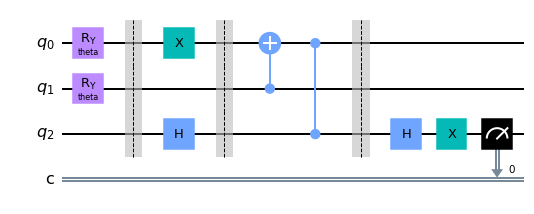

In [18]:

simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = AnomalyCircuit(simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw('mpl')


In [19]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        b = torch.tensor([gradients]).float() * grad_output.float()
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = AnomalyCircuit(backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)



In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(30, 45)
        self.lin2 = nn.Linear(45, 25)
        self.dropout = nn.Dropout2d(p = 0.15)
        self.fc1 = nn.Linear(25, 10)
        self.fc2 = nn.Linear(10, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, [np.pi,np.pi/2])

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)



In [21]:

df = pd.read_csv('creditcard.csv')
X = df.drop(columns=['Class']).values
y = df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

In [23]:
model = Net()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01)

In [24]:
batch_size=1
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

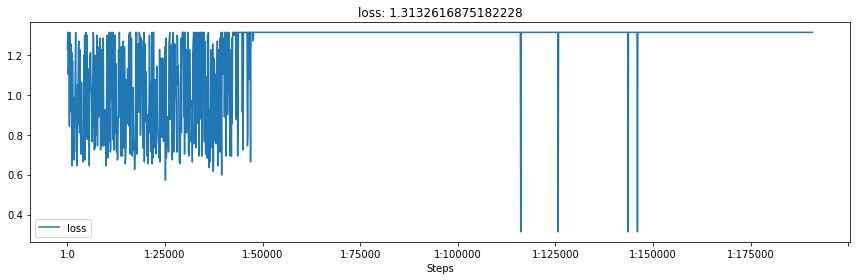

Training [100%]	Loss: 1.2403


In [25]:
import hiddenlayer as hl
epochs = 1
loss_list = []
history = hl.History()
canvas = hl.Canvas()
model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        if batch_idx%100 == 0:
            print('Epoca: {}, iteración {}/{}'.format(epoch,batch_idx,len(train_dl)))
            history.log((epoch+1, batch_idx), loss=loss)
            with canvas:
                canvas.draw_plot(history["loss"])
        total_loss.append(loss.item(), )
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Text(0, 0.5, 'Entropía')

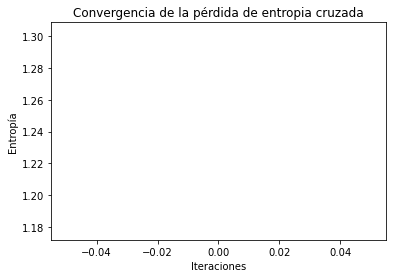

In [26]:
plt.plot(loss_list)
plt.title('Convergencia de la pérdida de entropia cruzada')
plt.xlabel('Iteraciones')
plt.ylabel('Entropía')

In [27]:
from sklearn.metrics import average_precision_score, classification_report
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
test_ds = torch.utils.data.TensorDataset(X_test, y_test)



In [28]:
%%time
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=True)
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data,target) in enumerate(test_loader):
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) 
        y_pred.append(pred)
        y_true.append(target)
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
y_pred = [x.item() for x in y_pred]
y_true = [x.item() for x in y_true]

Wall time: 36min 52s


In [29]:
print(average_precision_score(y_pred,y_true))

1.0


In [30]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.00      0.00     93987

    accuracy                           0.00     93987
   macro avg       0.50      0.00      0.00     93987
weighted avg       1.00      0.00      0.00     93987

